In [3]:
import pickle
import re
import pandas
import numpy as np
import numpy as np

from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA


from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage


#### Considering the motifs with the lowest possible p-values. That is with p-value < 1e-05

In [93]:
motifs_flagged = db.query("SELECT motif_string FROM motif_average_scores where tt_p_value = 0 ").getresult()
motifs_flagged = [motif_flagged[0] for motif_flagged in motifs_flagged] #from tuples to string

### Associating motifs flagged to their proteins 

In [147]:
%%time
protein_to_sequence = pickle.load( open( "../files/intermediates/proteins_to_sequences.pkl", "rb" ) )
distanceMatrix_df = pandas.read_pickle(open( "../files/intermediates/distanceMatrix.pkl", "rb" ))
motifs_to_proteins = {}
i = 0

for motif in motifs_flagged:
    if(i%1000 == 0):
        print("Done "+ str(i) + " out of " + str(len(motifs_flagged)))
    i+=1
    motifs_to_proteins[motif] = []
    for protein in protein_to_sequence:
        if(re.search(motif, protein_to_sequence[protein]) != None):
            motifs_to_proteins[motif].append(protein)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
CPU times: user 15min 23s, sys: 476 ms, total: 15min 23s
Wall time: 15min 23s


### The above took quite some time (7mins) so to avoid repeating I save as a pickle below

In [151]:
pickle.dump(motifs_to_proteins,open( "../files/intermediates/motifs_to_proteins.pkl", "wb" ))

### Calculating motifs distances (based off LESMoN)

In [220]:
%%time
# motifs_to_simularity = {}
motif_to_distance = {}
for motif_a in motifs_to_proteins:
#     motifs_to_simularity[motif_a] = {}
    motif_to_distance[motif_a] = {}
    for motif_b in motifs_to_proteins:
        numerator = len(set(motifs_to_proteins[motif_a] + motifs_to_proteins[motif_b]))
        denumerator = min(len(motifs_to_proteins[motif_a]), len(motifs_to_proteins[motif_b]))
#         motifs_to_simularity[motif_a][motif_b] = numerator/denumerator
        similarity = numerator/denumerator
        motif_to_distance[motif_a][motif_b] = 0 if(similarity == 1) else 1/(similarity - 1)

CPU times: user 5min 36s, sys: 5.12 s, total: 5min 41s
Wall time: 5min 44s


In [221]:
df = pandas.DataFrame(motif_to_distance, columns=motif_to_distance.keys(), index=motif_to_distance.keys())

### Plot of PCA reduced flagged motif distances

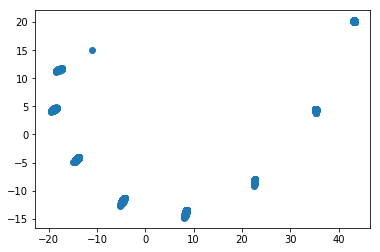

In [222]:
pca = PCA(n_components=2)
samples = np.array(df)

pc1 = pca.fit_transform(samples)
vis_x = pc1[:, 0]
vis_y = pc1[:, 1]
# vis_z = pc1[:, 2]
plt.scatter(vis_x, vis_y)
plt.show()


### Elbow chart method to find an optimal k. The above strongly suggests 9 clusters, but that is in the pca reduced dataset.

1
2
3
4
5
6
7
8
9
10
11
12
13
14


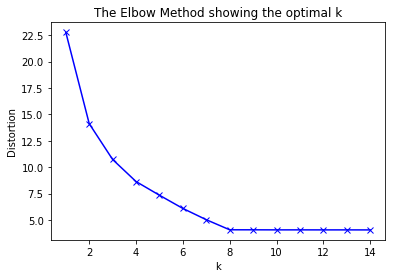

In [228]:

# create new plot and data
plt.plot()
X = np.array(df)
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']
 
# k means determine k
distortions = []
K = range(1,15)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### The above suggest 9 clusters so below I cluster my dataset into 8 using kmeans

In [234]:
km = KMeans(n_clusters=9).fit(X)
kmeans_distances = km.transform(X)
kmeans_distances_df = pandas.DataFrame(kmeans_distances)
kmeans_distances_df.min()

0    1.639713
1    1.187169
2    1.726419
3    1.179668
4    1.065889
5    1.420142
6    1.737431
7    2.596881
8    1.821847
dtype: float64

Below are the representitives motifs for each cluster. Not in any particular order. These motifs are the ones with the lowest distance to their centroids.

In [235]:
mins = kmeans_distances_df.idxmin()
families = []
for index in mins:
    families.append(motifs_flagged[index])
families

['tacgcttg',
 'cgtataag',
 'ctttacgg',
 'tacccgtc',
 'atacccgg',
 'ctataacg',
 'atagcccg',
 'acgagaac',
 'ccgtctat']

Its not hard to beleive that the differences in nucleotides is correlated with differences in proteins expressed. Since these are representitives of different clusters they should have fairly high differences.

Below are the Levenshtein distance between motifs strings of the representitives. 

A value of 0 is the minimum distance while a value of 8 is the maximum distance in this case.

In [236]:
def motif_similarity(motif_reggex_a, motif_reggex_b, distance_function):
    motif_reggex_formated_a = motif_reggex_a.replace(".", "[acgt]?")
    motif_strings_a = list(exrex.generate(motif_reggex_formated_a))
    motif_reggex_formated_b = motif_reggex_b.replace(".", "[acgt]?")
    motif_strings_b = list(exrex.generate(motif_reggex_formated_b))
    return np.array([[distance_function(a_i, b_i) for b_i in motif_strings_b] for a_i in motif_strings_a]).min()

def motif_levenshtein(motif_reggex_a, motif_reggex_b):
    return motif_similarity(motif_reggex_a, motif_reggex_b, distance.levenshtein)

distances = []
for motif_a in families:
    distances_motif_a = []
    for motif_b in families:
        distances_motif_a.append(motif_levenshtein(motif_a, motif_b))
    distances.append(distances_motif_a)
  
pandas.DataFrame(distances, index=families, columns=families)

,tacgcttg,cgtataag,ctttacgg,tacccgtc,atacccgg,ctataacg,atagcccg,acgagaac,ccgtctat
tacgcttg,0,6,6,3,4,6,4,6,5
cgtataag,6,0,4,7,6,2,6,4,4
ctttacgg,6,4,0,6,4,3,5,7,6
tacccgtc,3,7,6,0,3,6,4,5,6
atacccgg,4,6,4,3,0,5,2,7,7
ctataacg,6,2,3,6,5,0,4,4,6
atagcccg,4,6,5,4,2,4,0,5,7
acgagaac,6,4,7,5,7,4,5,0,5
ccgtctat,5,4,6,6,7,6,7,5,0
